## AIS Analyze Vessel Clusters

In [1]:
# from IPython.display import Image, HTML
import os
import numpy as np
import pandas as pd
import datetime
import warnings
from glob import glob

warnings.filterwarnings("ignore")           # Suppress Warning

In [2]:
WorkingFolder = "/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/"

In [3]:
OutputDir = "/Users/cv0361/Desktop/TechChallenge/Data/csv/ValidAIS/"

### Load Broadcast Data

In [266]:
folder = WorkingFolder + "Zone03_2017_01/"

Broadcast = pd.read_csv("/Users/cv0361/Desktop/TechChallenge/Data/csv/ValidAIS/Broadcast_Zone10_2014_01.csv", sep=",", parse_dates=['date_time'])
Broadcast.head()

,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
0,366025993,2013-12-31 23:57:44,47.581332,-122.361145,0.0,39.599998,1,511,0
1,367160890,2013-12-31 23:57:44,45.835737,-123.990592,6.7,355.399990,2,359,15
2,366490600,2013-12-31 23:57:44,47.631067,-122.382117,0.0,192.100010,3,180,7
3,338000406,2013-12-31 23:57:44,48.123443,-123.444115,0.0,14.200000,4,511,0
4,367840001,2013-12-31 23:57:44,48.121267,-122.726412,11.4,55.400002,5,57,0


In [267]:
print("Raw Count:", Broadcast.shape[0])

Raw Count: 21517764


### K-means
* https://github.com/JosephMagiya/Clustering-GPS-Co-ordinates--Forming-Regions./blob/master/Clustering-GPS-Co-ordinates--Forming-Regions.ipynb

In [236]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

In [297]:
# AIS_2017_01_Zone03
# ====================
# 367094420      ARCTIC MARINER 	 type: 1001 - Fishing, 31x9.28       lots of points   multiple trips, same route
# 367565680      ADAMANT             type: 1001 - Fishing, 18x8          lots of points   ?
# 367373760      NORTH SEA           type: 1001 - Fishing, 37x10                          ?
# 440102000      TORAH               type: 1004 - Freight, 115.8x16.62   lots of points   weird
# 636014222      Zim Rotter          type: 1004 - Freight, 349x45.73                      Going some where
# 367322830      GYRFALCON           type: 1025 - Towing, 30.63x10.4     lots of points   weird behavior

# Broadcast_Zone10_2014_01
# =========================
# 366025993



mmsi = 366025993 
voyage_id = np.nan

df = Broadcast.loc[Broadcast.mmsi_id==mmsi, ['date_time', 'lat', 'lon', 'speed_over_ground', 'voyage_id']]  # & (Broadcast.voyage_id.isnull()
df.rename(columns={'lat':'latitude', 'lon':'longitude'}, inplace=True)

df['PingDate'] = df['date_time'].dt.date
df['PingHour'] = df['date_time'].dt.hour

df.head()

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour
0,2013-12-31 23:57:44,47.581332,-122.361145,0.0,1,2013-12-31,23
273,2014-01-01 00:00:04,47.581350,-122.361145,0.0,1,2014-01-01,0
1145,2014-01-01 00:01:13,47.581368,-122.361160,0.0,1,2014-01-01,0
1648,2014-01-01 00:02:13,47.581340,-122.361163,0.0,1,2014-01-01,0
2107,2014-01-01 00:03:13,47.581355,-122.361163,0.0,1,2014-01-01,0


In [298]:
df.shape

(19019, 7)

In [299]:
# Get Unique voyage Id
df[['voyage_id']].drop_duplicates().head()

,voyage_id
0,1
29678,1086
1683658,2025
1698985,3251
4855938,5339


In [300]:
# # Select 1 voyage
# df = df.loc[df.voyage_id==1]
# df.shape

In [301]:
# df.describe()
df.agg(['count', 'max', 'min', 'mean', 'median', 'std'])   # uniquecount

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour
count,19019,19019.000000,19019.000000,19019.000000,19019.000000,19019,19019.000000
max,2014-01-31 23:59:02,48.107383,-122.219992,12.600000,22934.000000,2014-01-31,23.000000
min,2013-12-31 23:57:44,47.134330,-122.778048,0.000000,1.000000,2013-12-31,0.000000
mean,2014-01-17 04:38:26.313844224,47.572759,-122.427357,1.920443,10916.216994,NaN,13.463484
median,NaN,47.580410,-122.361237,0.000000,8599.000000,NaN,15.000000
std,NaN,0.134257,0.090293,3.452342,6318.438478,NaN,7.279956


In [303]:
mygroup = df.groupby(['voyage_id', 'PingDate', 'PingHour'])
sampling = mygroup['latitude', 'longitude', 'speed_over_ground'].mean()  
sampling['PingCount'] = mygroup['latitude'].count()
sampling.reset_index(inplace=True)
sampling.head(10)

,voyage_id,PingDate,PingHour,latitude,longitude,speed_over_ground,PingCount
0,1,2013-12-31,23,47.581332,-122.361145,0.000000,1
1,1,2014-01-01,0,47.581439,-122.361171,1.015254,59
2,1086,2014-01-01,1,47.607310,-122.438810,10.585294,34
3,2025,2014-01-03,13,47.621363,-122.519214,0.796552,29
4,3251,2014-01-03,14,47.602209,-122.418066,6.970175,57
5,3251,2014-01-03,15,47.580035,-122.361138,0.003448,58
6,3251,2014-01-03,16,47.580076,-122.360926,0.078571,56
7,3251,2014-01-03,17,47.580143,-122.361027,0.273214,56
8,3251,2014-01-03,18,47.579786,-122.361125,0.258621,58
9,3251,2014-01-03,19,47.579872,-122.361155,0.021429,56


In [304]:
sampling['Text'] = sampling.apply(lambda x: "{}:{}-V:{} - SOG: {} - Count: {} ({}, {})".format(x.PingDate, x.PingHour, x.voyage_id, round(x.speed_over_ground, 1), x.PingCount, round(x.latitude, 3), round(x.longitude, 3)), axis=1)   
sampling.head()

,voyage_id,PingDate,PingHour,latitude,longitude,speed_over_ground,PingCount,Text
0,1,2013-12-31,23,47.581332,-122.361145,0.000000,1,2013-12-31:23-V:1 - SOG: 0.0 - Count: 1 (47.58...
1,1,2014-01-01,0,47.581439,-122.361171,1.015254,59,2014-01-01:0-V:1 - SOG: 1.0 - Count: 59 (47.58...
2,1086,2014-01-01,1,47.607310,-122.438810,10.585294,34,2014-01-01:1-V:1086 - SOG: 10.6 - Count: 34 (4...
3,2025,2014-01-03,13,47.621363,-122.519214,0.796552,29,2014-01-03:13-V:2025 - SOG: 0.8 - Count: 29 (4...
4,3251,2014-01-03,14,47.602209,-122.418066,6.970175,57,2014-01-03:14-V:3251 - SOG: 7.0 - Count: 57 (4...


In [305]:
sampling.shape

(352, 8)

In [306]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

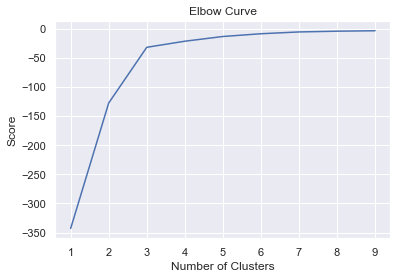

In [307]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [308]:
kmeans = KMeans(n_clusters = 7, init ='k-means++')

X = df[['latitude', 'longitude']]
kmeans.fit(X)                                   # Compute k-means clustering. # Compute k-means clustering.

df['cluster_label'] = kmeans.predict(X)                      # Labels of each point

centers = kmeans.cluster_centers_               # Coordinates of cluster centers.
# labels = kmeans.predict(X)                      # Labels of each point

df.head()

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour,cluster_label
0,2013-12-31 23:57:44,47.581332,-122.361145,0.0,1,2013-12-31,23,1
273,2014-01-01 00:00:04,47.581350,-122.361145,0.0,1,2014-01-01,0,1
1145,2014-01-01 00:01:13,47.581368,-122.361160,0.0,1,2014-01-01,0,1
1648,2014-01-01 00:02:13,47.581340,-122.361163,0.0,1,2014-01-01,0,1
2107,2014-01-01 00:03:13,47.581355,-122.361163,0.0,1,2014-01-01,0,1


In [309]:
centers

array([[  47.37915702, -122.52819641],
       [  47.57678668, -122.36029829],
       [  47.62148804, -122.51022522],
       [  48.02860808, -122.70486765],
       [  47.28375771, -122.39341092],
       [  47.16311914, -122.63406637],
       [  47.9145131 , -122.3916805 ]])

In [310]:
# Cluster, ping counts
PingCluster = df.groupby('cluster_label').agg({'date_time': ['count']})   #.reset_index()
PingCluster

,date_time
,count
cluster_label,
0,439
1,10458
2,5832
3,277
4,851
5,690
6,472


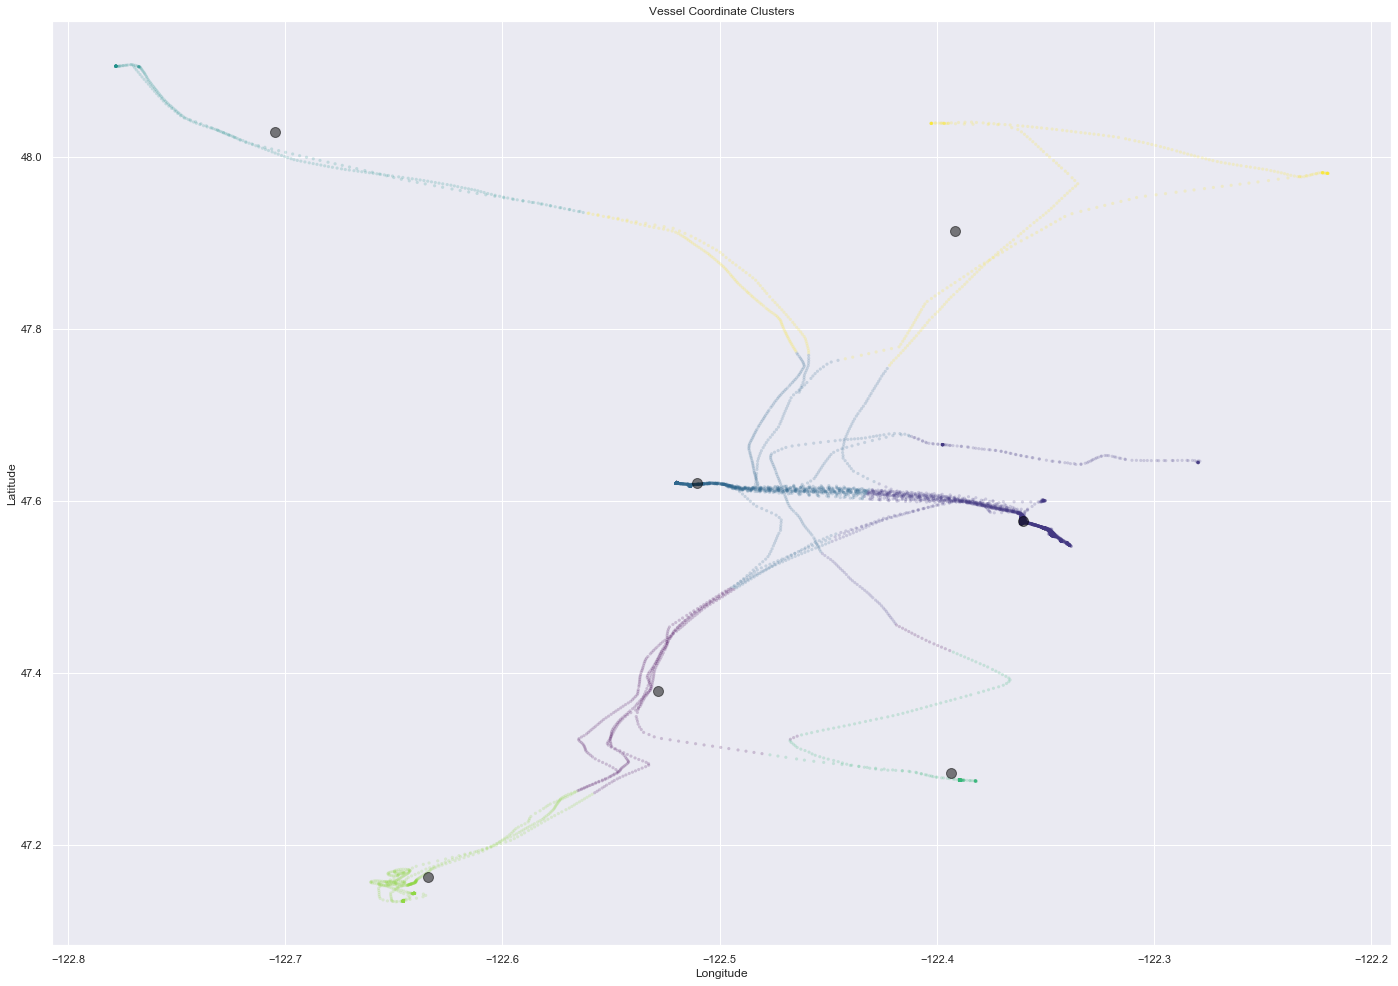

In [311]:
fig = plt.figure(figsize=(24,17))
ax = fig.add_subplot()

ax.scatter(df.longitude, df.latitude, s=10, lw=0, c=df['cluster_label'], cmap='viridis', alpha=0.2)
ax.scatter(centers[:, 1], centers[:, 0], c='black', s=100, alpha=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vessel Coordinate Clusters')
plt.show()

In [312]:
X = sampling  #.head()
MapCoordinates = X[['latitude', 'longitude']].values
PopupText = X.Text.values

mapit = folium.Map(location=MapCoordinates[0], zoom_start=8)

for index in range(0, len(MapCoordinates)):
    folium.Marker(MapCoordinates[index], popup=PopupText[index]).add_to(mapit)
    
# for coord in df[['latitude', 'longitude']].head().values:
#     folium.Marker(coord).add_to(mapit)

mapit

### Sample Folium
* https://github.com/python-visualization/folium
* https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium/blob/master/MapsTutorials.ipynb
* https://georgetsilva.github.io/posts/mapping-points-with-folium/

In [191]:
# import folium

# latlon = [(51.249443914705175, -0.13878830247011467), (51.249443914705175, -0.19), (51.249768239976866, -2.8610415615063034)]
# text = ['point1','point2','point3']

# mapit = folium.Map(location=[51.25, -1.2], zoom_start=9)

# for point in range(0, len(latlon)):
#     folium.Marker(latlon[point], popup=text[point]).add_to(mapit)

# # mapit.save( 'map.html')
# mapit

### Sample HDBSCAN
* https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html

In [26]:
from sklearn.datasets import make_blobs
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
blobs, labels = make_blobs(n_samples=2000, n_features=10)

In [8]:
pd.DataFrame(blobs).head()

,0,1,2,3,4,5,6,7,8,9
0,-1.264875,-8.260352,-7.672387,-4.457326,-2.654197,4.046740,4.732487,-8.031294,-3.358178,0.746357
1,-4.789295,5.347213,-9.076223,-2.658427,7.980381,6.582558,-2.511977,9.363582,9.516691,-6.797194
2,-8.840059,4.799937,-8.509396,1.783674,5.945335,-6.128442,-8.588533,-1.142080,8.091949,9.063377
3,-6.527711,5.229888,-8.250775,-0.308170,6.792324,5.278408,-1.254370,5.681781,9.835620,-6.410695
4,-8.316694,6.439864,-9.477828,-0.442857,4.329686,-4.317371,-8.836133,-2.024001,9.477133,8.406125


In [22]:
blobs.shape

(2000, 10)

In [23]:
blobs

array([[ -1.26487527,  -8.2603524 ,  -7.67238674, ...,  -8.03129446,
         -3.35817837,   0.74635706],
       [ -4.78929506,   5.34721314,  -9.0762227 , ...,   9.36358247,
          9.51669117,  -6.79719369],
       [ -8.84005935,   4.79993719,  -8.50939632, ...,  -1.14208   ,
          8.09194909,   9.06337698],
       ...,
       [ -1.48204497,  -7.86863968,  -8.58340059, ...,  -9.08749093,
         -2.90563069,  -1.05112635],
       [ -1.86398912,  -9.04289069,  -8.43069477, ..., -10.74356022,
         -2.72570248,   0.7149232 ],
       [ -3.82640572,   5.8166833 ,  -8.18621666, ...,   6.85105027,
          9.21200197,  -7.92391158]])

In [34]:
data = blobs.T[:,0:2]

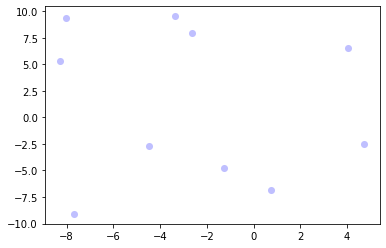

In [35]:
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

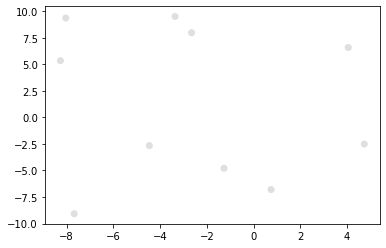

In [36]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [37]:
clusterer.condensed_tree_

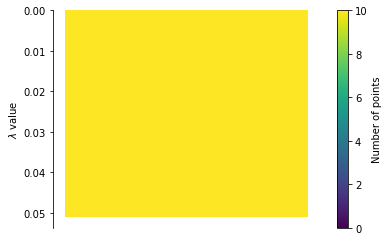

In [38]:
clusterer.condensed_tree_.plot()

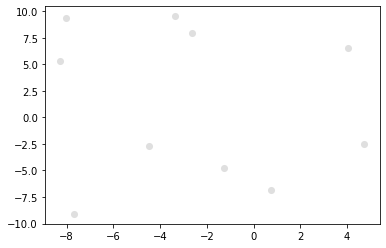

In [39]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

In [32]:
blobs.T[:,0:2].shape

(10, 2)

In [10]:
clusterer = hdbscan.HDBSCAN()

In [11]:
clusterer.fit(blobs)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [24]:
len(clusterer.labels_)

2000

In [12]:
clusterer.labels_

array([0, 1, 2, ..., 0, 0, 1])

In [13]:
clusterer.labels_.max()

2

In [14]:
clusterer.probabilities_

array([0.65203928, 0.80439755, 0.82601858, ..., 1.        , 0.62995029,
       0.62921136])

In [15]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusterer.fit(blobs)
clusterer.labels_

array([0, 1, 2, ..., 0, 0, 1])

In [16]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

In [17]:
from sklearn.metrics.pairwise import pairwise_distances

In [18]:
distance_matrix = pairwise_distances(blobs)

In [19]:
distance_matrix

array([[ 0.        , 30.00083681, 29.50051889, ...,  3.55500992,
         4.3568916 , 29.92376286],
       [30.00083681,  0.        , 24.56326019, ..., 29.60063764,
        32.27173609,  5.39005198],
       [29.50051889, 24.56326019,  0.        , ..., 30.14754856,
        30.84141333, 23.7567574 ],
       ...,
       [ 3.55500992, 29.60063764, 30.14754856, ...,  0.        ,
         4.06465649, 29.23320791],
       [ 4.3568916 , 32.27173609, 30.84141333, ...,  4.06465649,
         0.        , 31.76605252],
       [29.92376286,  5.39005198, 23.7567574 , ..., 29.23320791,
        31.76605252,  0.        ]])

In [20]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(distance_matrix)
clusterer.labels_

array([0, 2, 1, ..., 0, 0, 2])